In [2]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from datetime import datetime
import sys
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)

In [3]:
# Get the current working directory (which should be 'notebooks/')
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Add the 'data' directory to the path
sys.path.insert(0, os.path.join(parent_dir, 'data'))

# Now you can import your module
from measurments import get_measurments


# 1. Connection Settings

In [4]:
# Load .env file
load_dotenv()

# Get the EC2 tracking server host from the environment variable
EC2_TRACKING_SERVER_HOST = os.getenv('EC2_TRACKING_SERVER_HOST')
EC2_ENDPOINT = f"http://{EC2_TRACKING_SERVER_HOST}:8000"

# Parameters for the RDS PostgreSQL instance
PG_HOST = os.getenv('PG_HOST')
PG_PORT = os.getenv('PG_PORT')
PG_DATABASE = os.getenv('PG_DATABASE')
PG_USER = os.getenv('PG_USER')
PG_PASSWORD = os.getenv('PG_PASSWORD')

# Create the MySQL database connection string
db_url = f'postgresql+psycopg2://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DATABASE}'

In [4]:
def ingest_rds(df, table_name, mode):
    engine = create_engine(db_url)
    connection = engine.connect()
    df.to_sql(table_name, engine, if_exists=mode, index=False)
    connection.close()

In [6]:
def select_from_rds(query):
    engine = create_engine(db_url)
    connection = engine.connect()
    df = pd.read_sql(query, connection)
    connection.close()
    return df

# 2. Kuznica setup

In [7]:
df_measurments_kuznica = get_measurments(station = 'kuznica',past_days=1020)

/Users/krystianpietrzak/Documents/ML/WindPRO/data/measurments.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_i])


In [11]:
ingest_rds(df_measurments_kuznica, 'measurments_kuznica', 'replace')

In [17]:
df_measurments = select_from_rds('select * from measurments_kuznica')
df_measurments

,Time,WindSpeed,WindGust,Update
0,2021-01-23 00:00:00,7.19,7.97,2023-11-09 18:51:40.594281
1,2021-01-23 00:10:00,7.19,7.97,2023-11-09 18:51:40.594281
2,2021-01-23 00:20:00,7.19,7.97,2023-11-09 18:51:40.594281
3,2021-01-23 00:30:00,7.19,7.97,2023-11-09 18:51:40.594281
4,2021-01-23 00:40:00,7.19,7.97,2023-11-09 18:51:40.594281
...,...,...,...,...
143667,2023-11-09 01:30:00,10.50,13.80,2023-11-09 18:51:40.594281
143668,2023-11-09 01:40:00,9.91,11.86,2023-11-09 18:51:40.594281
143669,2023-11-09 01:50:00,9.91,13.22,2023-11-09 18:51:40.594281
143670,2023-11-09 02:00:00,8.55,11.86,2023-11-09 18:51:40.594281


In [18]:
df_forecast = select_from_rds('select * from forecast')
df_forecast

,Time,Month,Hour,WindForecast,GustForecast,WindDirForecast,Temperature,Precipitation,Cloudcover,Update
0,2021-01-01 02:00:00,1,2,7.0,12.00,191.0,2.00,0.0,97.0,2023-10-03
1,2021-01-01 04:00:00,1,4,7.0,11.00,184.0,2.00,0.0,26.0,2023-10-03
2,2021-01-01 06:00:00,1,6,8.0,12.00,171.0,2.00,0.0,100.0,2023-10-03
3,2021-01-01 08:00:00,1,8,9.0,13.00,166.0,2.00,0.0,100.0,2023-10-03
4,2021-01-01 10:00:00,1,10,9.0,14.00,164.0,2.00,0.0,100.0,2023-10-03
...,...,...,...,...,...,...,...,...,...,...
12138,2023-10-30 14:00:00,10,14,9.2,17.20,228.5,13.50,0.0,100.0,2023-10-30
12139,2023-10-30 16:00:00,10,16,6.7,11.45,205.0,11.75,0.0,100.0,2023-10-30
12140,2023-10-30 18:00:00,10,18,8.0,18.00,196.5,10.75,0.0,98.0,2023-10-30
12141,2023-10-30 20:00:00,10,20,7.0,17.10,199.0,10.45,0.0,100.0,2023-10-30


In [19]:
# Set the 'Time' column as the index
df_measurments.set_index('Time', inplace=True)

# Resample the data with a two-hour interval and apply mean aggregation
df_measurments = df_measurments.resample('2H').mean()

df_measurments.reset_index(inplace=True)

df = pd.merge(left=df_forecast, right=df_measurments, on='Time', how='inner')

df.dropna(inplace=True)
df

,Time,Month,Hour,WindForecast,GustForecast,WindDirForecast,Temperature,Precipitation,Cloudcover,Update_x,WindSpeed,WindGust,Update_y
3,2021-01-23 00:00:00,1,0,5.00,10.00,208.0,4.00,0.00,100.0,2023-10-03,7.368333,8.438333,2023-11-09 18:51:40.594281216
4,2021-01-23 02:00:00,1,2,7.00,17.00,237.0,3.00,0.00,100.0,2023-10-03,7.208333,8.697500,2023-11-09 18:51:40.594281216
5,2021-01-23 04:00:00,1,4,9.00,19.00,243.0,3.00,0.00,74.0,2023-10-03,3.920000,5.670833,2023-11-09 18:51:40.594281216
6,2021-01-23 06:00:00,1,6,8.00,16.00,237.0,2.00,0.00,99.0,2023-10-03,6.010000,8.342500,2023-11-09 18:51:40.594281216
7,2021-01-23 08:00:00,1,8,4.00,7.00,206.0,2.00,0.00,98.0,2023-10-03,2.363333,3.547500,2023-11-09 18:51:40.594281216
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2023-11-08 14:00:00,11,14,11.55,19.65,226.5,8.70,0.95,100.0,2023-11-08,12.150000,16.295833,2023-11-09 18:51:40.594281216
11876,2023-11-08 16:00:00,11,16,13.95,23.60,239.0,8.95,0.15,97.5,2023-11-08,12.115000,15.372500,2023-11-09 18:51:40.594281216
11877,2023-11-08 18:00:00,11,18,14.35,24.30,246.5,8.85,0.05,98.5,2023-11-08,14.627500,18.205000,2023-11-09 18:51:40.594281216
11878,2023-11-08 20:00:00,11,20,14.65,24.50,245.5,8.75,0.00,98.0,2023-11-08,14.158333,17.607500,2023-11-09 18:51:40.594281216


# MLFLOW exploration

In [19]:
def get_config():
    # Load .env file
    load_dotenv()

    # Get the EC2 tracking server host from the environment variable
    EC2_TRACKING_SERVER_HOST = os.getenv('EC2_TRACKING_SERVER_HOST')
    EC2_ENDPOINT = f"http://{EC2_TRACKING_SERVER_HOST}:8000"

    # Parameters for the RDS PostgreSQL instance
    PG_HOST = os.getenv('PG_HOST')
    PG_PORT = os.getenv('PG_PORT')
    PG_DATABASE = os.getenv('PG_DATABASE')
    PG_USER = os.getenv('PG_USER')
    PG_PASSWORD = os.getenv('PG_PASSWORD')

    # Create the MySQL database connection string
    db_url = f'postgresql+psycopg2://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DATABASE}'

    return db_url

def get_test_metrics():
    db_url = get_config()

    engine = create_engine(db_url)

    # Use the engine to connect to the database
    connection = engine.connect()

    df_metrics = pd.read_sql('select * from latest_metrics', connection)
    df_params = pd.read_sql('select * from params', connection)
    df_runs = pd.read_sql('select * from runs', connection)
    
    connection.close()

    df_params.rename(columns={'key': 'param', 'value': 'param_value'}, inplace=True)

    df_metrics_runs = pd.merge(left=df_metrics, right=df_runs, how='left', on='run_uuid')
    df_metrics_runs = df_metrics_runs[df_metrics_runs['name'].str.contains('test')].drop_duplicates()
    df_metrics_runs['date'] = df_metrics_runs['name'].str.extract(r'test_run_prod_(\d{4}-\d{2}-\d{2}-\d{2}-\d{2})')

    # Convert the extracted string to a datetime object
    df_metrics_runs['date'] = pd.to_datetime(df_metrics_runs['date'], format='%Y-%m-%d-%H-%M')

    df_joined = pd.merge(left=df_metrics_runs, right=df_params, how='inner', on='run_uuid')
    df_joined = df_joined[df_joined['experiment_id'] == 1]
    df_joined = df_joined[df_joined['param_value'].isin(['gust', 'base', 'rewa', 'kuznica'])]
    df_joined = df_joined[df_joined['key'].isin(['test_rmse','forecast_rmse'])]
    df_joined = df_joined.sort_values(by='date', ascending=False).head(16)
    
    df_result = df_joined.groupby('timestamp').agg({
        'param_value': lambda x: ', '.join(map(str, x)),
        'key': 'first',
        'value': 'first'
    }).reset_index()[['param_value','key','value']]

    df_result['param_value'] = df_result['param_value'].apply(lambda x: ', '.join(sorted(x.split(', '))))
    df_result = df_result.pivot_table(index='param_value', columns='key', values='value').reset_index()[['param_value','forecast_rmse','test_rmse']]
    
    df_result.rename(columns={'forecast_rmse':'Forecast Accuracy (RMSE)', 'test_rmse':'WindPRO Accuracy (RMSE)', 'param_value': 'Model'}, inplace = True )
    df_result['Improvement [%]'] = (df_result['Forecast Accuracy (RMSE)'] - df_result['WindPRO Accuracy (RMSE)'])/df_result['Forecast Accuracy (RMSE)'] * 100
    return df_result


get_test_metrics()
    

key,Model,Forecast Accuracy (RMSE),WindPRO Accuracy (RMSE),Improvement [%]
0,"base, kuznica",3.457866,2.683390,22.397527
1,"base, rewa",3.870957,2.987878,22.812937
2,"gust, kuznica",3.913737,3.312990,15.349694
3,"gust, rewa",3.697221,2.940401,20.469977


/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_37859/1471476331.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_37859/1471476331.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_37859/1471476331.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

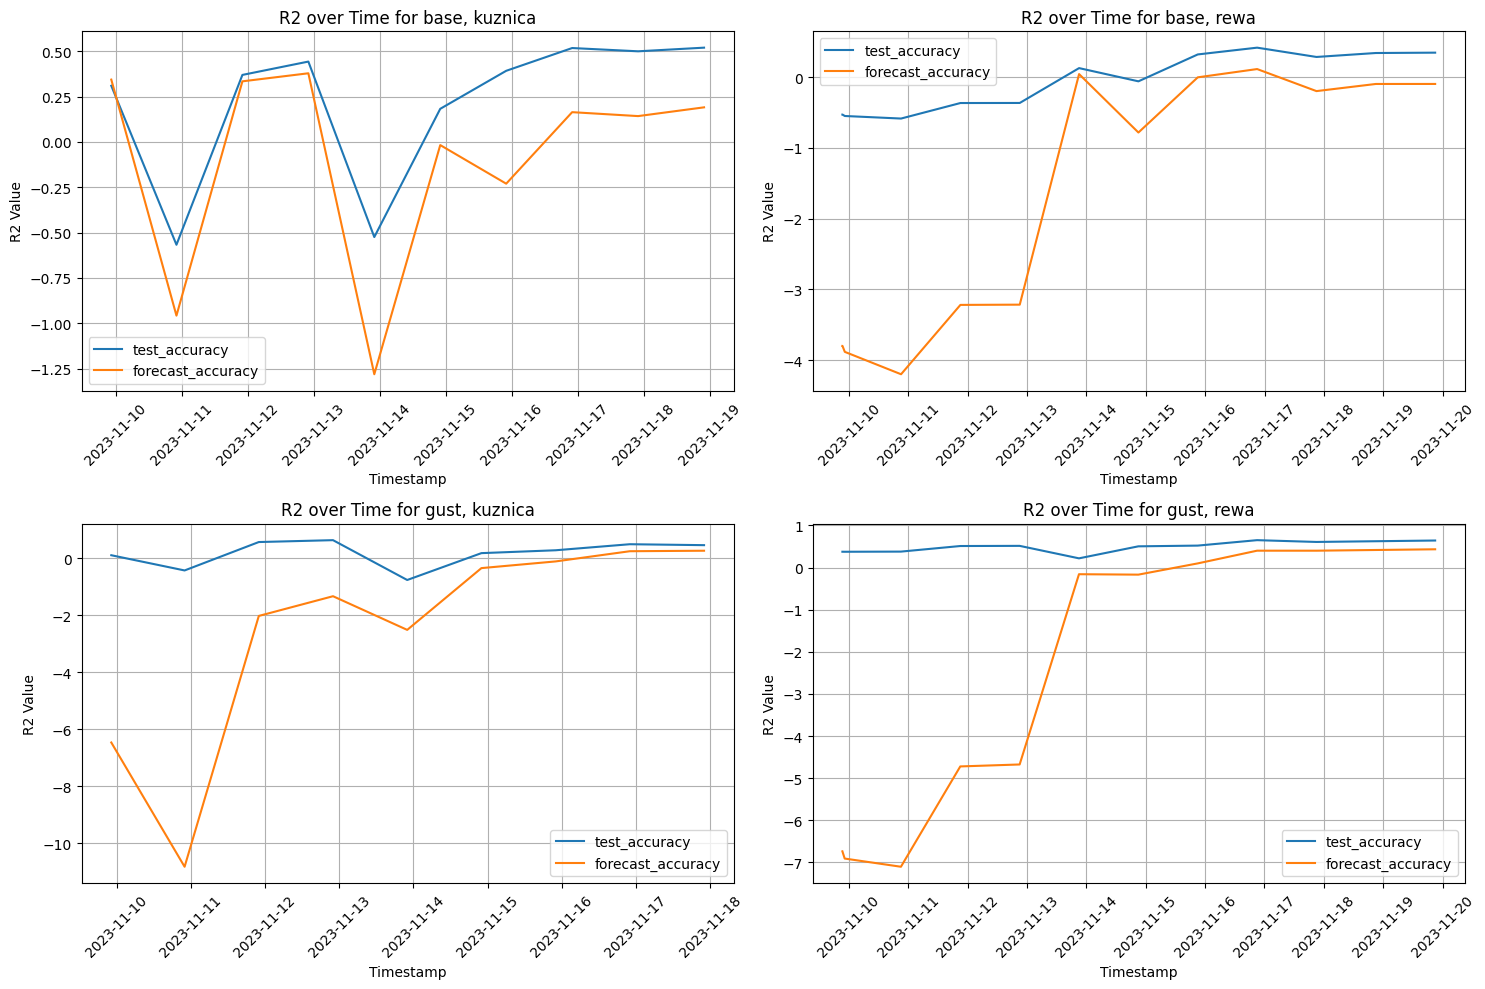

In [9]:
def plot_test_metrics():
    db_url = get_config()

    engine = create_engine(db_url)

    # Use the engine to connect to the database
    connection = engine.connect()

    df_metrics = pd.read_sql('select * from latest_metrics', connection)
    df_params = pd.read_sql('select * from params', connection)
    df_runs = pd.read_sql('select * from runs', connection)
    
    connection.close()

    df_params.rename(columns={'key': 'param', 'value': 'param_value'}, inplace=True)

    df_metrics_runs = pd.merge(left=df_metrics, right=df_runs, how='left', on='run_uuid')
    df_metrics_runs = df_metrics_runs[df_metrics_runs['name'].str.contains('test')].drop_duplicates()
    df_metrics_runs['date'] = df_metrics_runs['name'].str.extract(r'test_run_prod_(\d{4}-\d{2}-\d{2}-\d{2}-\d{2})')

    # Convert the extracted string to a datetime object
    df_metrics_runs['date'] = pd.to_datetime(df_metrics_runs['date'], format='%Y-%m-%d-%H-%M')

    df_joined = pd.merge(left=df_metrics_runs, right=df_params, how='inner', on='run_uuid')
    df_joined = df_joined[df_joined['param_value'].isin(['gust', 'base', 'rewa', 'kuznica'])]
    df_joined = df_joined[df_joined['key'].isin(['test_accuracy', 'forecast_accuracy'])]

    df_accuracy = df_joined[['key','value','date','param_value','timestamp']].groupby('timestamp').agg({
                        'param_value': lambda x: ', '.join(map(str, x)),
                        'key': 'first',
                        'value': 'first',
                        'date': 'first'}).reset_index()
    
    df_accuracy = df_accuracy[df_accuracy['param_value'].str.contains(',')]

    def convert_timestamp_to_date(timestamp):
        return datetime.fromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')
    
    # Apply the conversion function to the timestamp column
    df_accuracy['timestamp'] = df_accuracy['timestamp'].apply(convert_timestamp_to_date)

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    params = ['base, kuznica', 'base, rewa', 'gust, kuznica', 'gust, rewa']
    axs = axs.flatten()
    for idx, param in enumerate(params):
        df = df_accuracy[df_accuracy['param_value'] == param]
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values(by='timestamp')

        for key in df['key'].unique():
            sub_df = df[df['key'] == key]
            axs[idx].plot(sub_df['timestamp'], sub_df['value'], label=key)

            axs[idx].set_xlabel('Timestamp')
            axs[idx].set_ylabel('R2 Value')
            axs[idx].set_title(f'R2 over Time for {param}')
            axs[idx].legend()
            axs[idx].grid(True)
            plt.setp(axs[idx].xaxis.get_majorticklabels(), rotation=45)
                       
        
    plt.tight_layout()
    
    
    plt.show()
        
plot_test_metrics()
